In [9]:
import math
import pickle
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm

In [105]:
# Descargamos y abrimos los datos necesarios
file = open("Datos/SP500_daily.pkl", "rb")
data_SP500 = pickle.load(file)
file.close()

vix_data = yf.download(tickers="^VIX", end='2022-11-01', 
                                    start='2000-01-01', interval="1d").Close



precios_data = yf.download("^GSPC", end='2022-11-03', 
                                    start='2000-01-01', interval="1d").Close

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [112]:
# Descargamos y cambiamos nombres de un par de tickers que daban problemas
lista_tickers = np.load("Datos/tickers_yahoo.npy", allow_pickle = True)
lista_tickers = list(map(lambda x: x.replace('BRK.B', 'BRK-B'), lista_tickers))
lista_tickers = list(map(lambda x: x.replace('BF.B', 'BF-B'), lista_tickers))

In [124]:
# Importamos la tasa libre de riesgo
rf = pd.read_csv('Datos/risk_free_rate.csv')
rf = rf[::-1]
rf.index = pd.to_datetime(rf.date)
rf.index = rf.index.date
rf = rf[" value"]/100


# Calculamos la Varianza esperada
IV = (vix_data / 100) ** 2
IV = IV[::-1] 
IV.index = IV.index.date


# Calculamos la aproximacion discreta de la varianza realizada
var_diaria = {}
for i, date_time in enumerate(data_SP500.index):
    if i + 1 == len(data_SP500.index):
        break
    
    if date_time.date() != data_SP500.index[i + 1].date():
        continue
        
    var_diaria[date_time.date()] = var_diaria.get(date_time.date(), 0) + math.log(data_SP500.iloc[i] / data_SP500.iloc[i + 1]) ** 2    
var_diaria = pd.DataFrame(var_diaria.items()).rename(columns = {0: 'Date', 1: "Daily_VAR"}).set_index("Date")    

window = 21
RV20 = var_diaria.rolling(window).sum().shift(- (window - 1)).rename(columns = {"Daily_VAR": "RV_20"})


# Calculamos la Prima de Riesgo de la Varianza
VRP = IV.subtract(RV20.RV_20).dropna()
VRP = VRP[::-1]

# Realizamos las predicciones haciendo uso de los modelos basados en CAPM

In [109]:
# Definimos la función para calcular betas
def beta(stock_ret, market_ret, window = 21):
        cov = stock_ret.rolling(window * 24).cov(market_ret).shift(- window * 24)
        market_var = market_ret.rolling(window * 24).var().shift(- window * 24)
        beta = cov / market_var
        return beta
    
stocks = pd.read_csv("Datos/tabla_precios.csv")
stocks.index = pd.to_datetime(stocks.Date)
stocks = stocks.drop("Date", axis = 1)
stocks.index = stocks.index.date

fechas = VRP.index
data_VRP = VRP

# Empezamos con las predicciones
predicciones =  {ticker: {} for ticker in lista_tickers}
for fecha in tqdm(fechas[::-1][21*24:]):
    VRP_forpredict = data_VRP.loc[fecha]
    precios = precios_data[::-1]
    precios.index = precios.index.date
    precios = precios.loc[fecha:] # Cogemos solamente fechas anteriores a la prediccion
    
    window = 21
    NextMonthReturn_byDay = np.log(precios.shift(window) / precios).dropna()
    NM_Excess_MR = NextMonthReturn_byDay.subtract(rf).dropna()
    NM_Excess_MR = NM_Excess_MR[::-1]

    # Igualamos tamaños
    NM_Excess_MR = NM_Excess_MR.subtract(VRP * 0).dropna()
    NM_Excess_MR = NM_Excess_MR[::-1]
    VRP = VRP.subtract(NM_Excess_MR * 0).dropna()
    VRP = VRP.rename("VRP")
    
    
    #Primera regresion para calcular rentabilidad del mercado esperada
    X = VRP[::-1]
    Y = NM_Excess_MR

    X = sm.add_constant(X)
    model_1 = sm.OLS(Y, X).fit()
    
    c1 = model_1.params[0]
    c2 = model_1.params[1]

    E_MR_1 = c1 + c2 * VRP
    E_MR_1 = E_MR_1[::-1]
    
    
    window = 21
    MarketReturn_Past_og = np.log(precios / precios.shift(-21)).dropna()
    
    for ticker in lista_tickers:
        if np.isnan(stocks.loc[fecha, ticker]):
            continue
        #print(ticker)
        stock = stocks.loc[:, ticker]
        stock = stock[::-1]

        # Calculamos las rentabilidades originales para ajustar el modelo
        window = 21
        stock_ret = np.log(stock / stock.shift(-21)).dropna()



        # Tener mismos tamaños
        stock_ret = stock_ret.subtract(MarketReturn_Past_og * 0).dropna()
        MarketReturn_Past = MarketReturn_Past_og.subtract(stock_ret * 0).dropna()
        stock_ret = stock_ret[::-1]
        MarketReturn_Past = MarketReturn_Past[::-1]

        stock_beta = beta(stock_ret, MarketReturn_Past).dropna()
        if len(stock_beta) == 0:
            continue
        
        
        #Segunda regresión para calular la rentabilidad esperada de las acciones
        X = (stock_beta * E_MR_1).dropna()
        X = X.rename("Beta * E_MR_1")
        X = X[::-1]
        
        window = 21
        NM_stock_ret = np.log(stock.shift(window) / stock).dropna()

        NM_stock_excess_ret = NM_stock_ret.subtract(rf).dropna()
        NM_stock_excess_ret = NM_stock_excess_ret[::-1]

        Y = NM_stock_excess_ret.subtract(X * 0).dropna()
        Y = Y[::-1]

        X = sm.add_constant(X)
        model_beta = sm.OLS(Y, X).fit()
        

        b1 = model_beta.params[0]
        b2 = model_beta.params[1]
        
        
        pred_EMR1 = c1 + c2 * VRP_forpredict
        pred_ER1 = b1 + b2 * (stock_beta[0] * pred_EMR1)
        #print(fecha, ticker, pred_ER1)
        predicciones[ticker][fecha] = pred_ER1
        #print(predicciones)

100%|███████████████████████████████████████| 2884/2884 [01:42<00:00, 28.07it/s]


In [ ]:
# Este archivo alimentará a nuestro robot para operar en función de las predicciones según cada momento en el tiempo
with open("/PrediccionesCAPM.pkl", 'wb') as file:
    pickle.dump(predicciones, file)

## Analizamos las Betas a lo largo del tiempo

In [126]:
# Definimos la función para calcular betas
def beta(stock_ret, market_ret, window = 21):
        cov = stock_ret.rolling(window * 24).cov(market_ret).shift(- window * 24)
        market_var = market_ret.rolling(window * 24).var().shift(- window * 24)
        beta = cov / market_var
        return beta
    
stocks = pd.read_csv("Datos/tabla_precios.csv")
stocks.index = pd.to_datetime(stocks.Date)
stocks = stocks.drop("Date", axis = 1)
stocks.index = stocks.index.date

fechas = VRP.index
data_VRP = VRP
betas = np.array([])

# Empezamos con las predicciones
predicciones =  {ticker: {} for ticker in lista_tickers}
for fecha in tqdm(fechas[::-1][-1:]):
    VRP_forpredict = data_VRP.loc[fecha]
    precios = precios_data[::-1]
    precios.index = precios.index.date
    precios = precios.loc[fecha:] # Cogemos solamente fechas anteriores a la prediccion
    
    window = 21
    NextMonthReturn_byDay = np.log(precios.shift(window) / precios).dropna()
    NM_Excess_MR = NextMonthReturn_byDay.subtract(rf).dropna()
    NM_Excess_MR = NM_Excess_MR[::-1]

    # Igualamos tamaños
    NM_Excess_MR = NM_Excess_MR.subtract(VRP * 0).dropna()
    NM_Excess_MR = NM_Excess_MR[::-1]
    VRP = VRP.subtract(NM_Excess_MR * 0).dropna()
    VRP = VRP.rename("VRP")
    
    
    #Primera regresion para calcular rentabilidad del mercado esperada
    X = VRP[::-1]
    Y = NM_Excess_MR

    X = sm.add_constant(X)
    model_1 = sm.OLS(Y, X).fit()
    
    c1 = model_1.params[0]
    c2 = model_1.params[1]

    E_MR_1 = c1 + c2 * VRP
    E_MR_1 = E_MR_1[::-1]
    
    
    window = 21
    MarketReturn_Past_og = np.log(precios / precios.shift(-21)).dropna()
    
    for ticker in lista_tickers:
        if np.isnan(stocks.loc[fecha, ticker]):
            continue
        #print(ticker)
        stock = stocks.loc[:, ticker]
        stock = stock[::-1]

        # Calculamos las rentabilidades originales para ajustar el modelo
        window = 21
        stock_ret = np.log(stock / stock.shift(-21)).dropna()



        # Tener mismos tamaños
        stock_ret = stock_ret.subtract(MarketReturn_Past_og * 0).dropna()
        MarketReturn_Past = MarketReturn_Past_og.subtract(stock_ret * 0).dropna()
        stock_ret = stock_ret[::-1]
        MarketReturn_Past = MarketReturn_Past[::-1]

        stock_beta = beta(stock_ret, MarketReturn_Past).dropna()
        betas = np.concatenate((betas,stock_beta))

100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.08s/it]


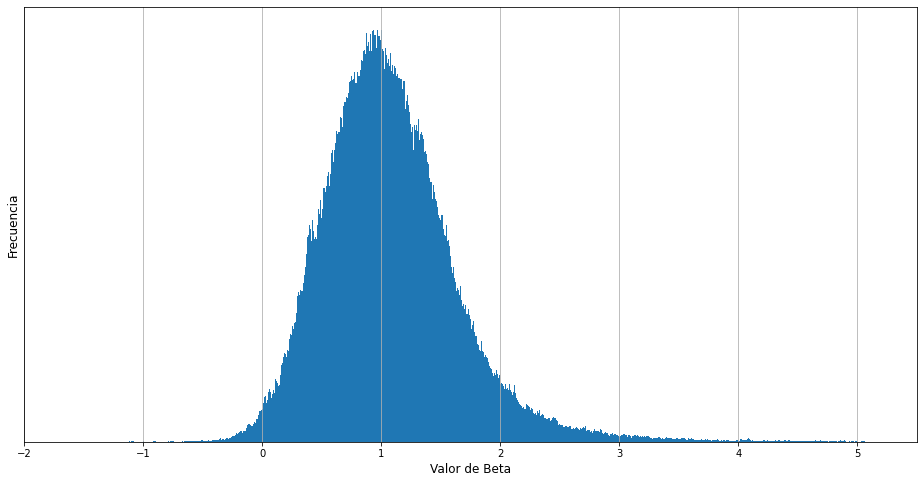

In [136]:
plt.figure(figsize=(16, 8))    
pd.Series(betas).hist(bins = 1000)
plt.xlim(-2, 5.5)
plt.yticks([])
plt.ylabel("Frecuencia", fontsize=12)
plt.xlabel("Valor de Beta", fontsize=12)
plt.show()